Author: Fei Li

Date: Oct. 23rd 2018



In [1]:
# numpy and pandas
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Hierarchical clustering
from scipy.cluster.hierarchy import linkage, cut_tree
from scipy.cluster.hierarchy import dendrogram
# K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

## Principal Component Analysis

In [2]:
path = '/Users/francis/Desktop/DSBA/Statistics and Probability/assignment-2-data/'
# path = ''
df = pd.read_csv(path + 'wines_properties.csv')

In [3]:
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [4]:
# Get the data matrix. The last column (the classification) is excluded.
X = df.iloc[:, 0:-1]
# Standardize the data
X_s = StandardScaler().fit_transform(X)
# PCA instance
pca = PCA(n_components=2)
# Project the data
X_p = pca.fit_transform(X_s)

In [5]:
PCs = pca.components_
PCs.shape

(2, 13)

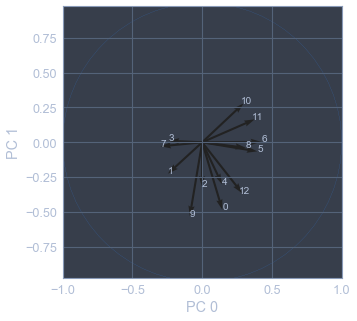

In [6]:
# "Circle of correlations"
# Get the PCA components (loadings)
PCs = pca.components_
# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)
# Add labels based on feature names (here just numbers)
feature_names = np.arange(PCs.shape[1])
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')
# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)
# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')
# Done
plt.show()

In [7]:
for i, feature in enumerate(df.columns.values[:-1]):
    print(i, feature)

0 Alcohol
1 Malic_Acid
2 Ash
3 Ash_Alcanity
4 Magnesium
5 Total_Phenols
6 Flavanoids
7 Nonflavanoid_Phenols
8 Proanthocyanins
9 Color_Intensity
10 Hue
11 OD280
12 Proline


* From the circle of correlations, we can see that the first component gives more positive weights to feature 5 and 6, namely Total_Phenols and Flavanoids, while it maybe negatively correlated with 7 (Nonflavanoid_Phenols) and 1 (Malic_Acid). 
* By looking at the vertical axis, we see that the second component gives more positive weights to feature 10 and 11, i.e. Hue and OD280. It gives the largest negative weights to 9 (Color_Intensity) and 0 (Alcohol), so it may have a strong negative correlation with them.

The above statements can be verified by calculating the correlation between the two components and the original variables respectively.

In [8]:
# construct table of correlations between the first two components and the variables respectively
table = pd.DataFrame(index=df.columns.values[:-1], columns=['First Component', 'Second Component'])
for i in range(X_s.shape[-1]):  # correlation of the first component with each variable
    table.iloc[i, 0] = np.corrcoef(X_s[:, i], X_p[:, 0])[0,1]
for i in range(X_s.shape[-1]):  # correlation of the second component with each variable
    table.iloc[i, 1] = np.corrcoef(X_s[:, i], X_p[:, 1])[0,1]

# color the high correlations
def color_red(val):
    color = 'red' if np.abs(val) > 0.7 else 'black'
    return 'color: %s' % color        
s = table.style.applymap(color_red)
s

,First Component,Second Component
Alcohol,0.313093,-0.764257
Malic_Acid,-0.531885,-0.355432
Ash,-0.00444936,-0.499446
Ash_Alcanity,-0.519157,0.0167349
Magnesium,0.308023,-0.473476
Total_Phenols,0.856137,-0.102774
Flavanoids,0.91747,0.00530911
Nonflavanoid_Phenols,-0.647607,-0.0454768
Proanthocyanins,0.679922,-0.0621039
Color_Intensity,-0.192236,-0.837489


As can be seen from the table, the first component is strongly correlated with `Total_Phenols` and `Flavanoids`. The second component has strong negative correlations with `Alcohol` and `Color_Intensity`. 


## Hierarchical Clustering

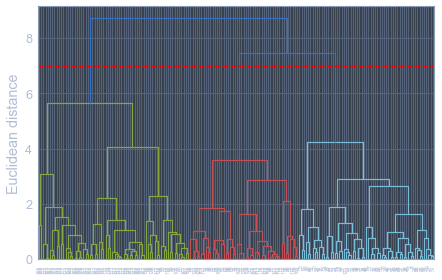

In [9]:
# cluster the projected data X_p
row_clusters = linkage(X_p, method='complete', metric='euclidean')
row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.axhline(y=7, color='red', linestyle="--")
plt.show()

From the dendogram, a likely number of cluster is 3, as can be seen from the number of crossovers made by the red horizontal line.

## K-means Clustering Algorithm

In [10]:
# KMeans instance
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
# partition (or clustering) of the data
partition = kmeans.fit_predict(X_p)

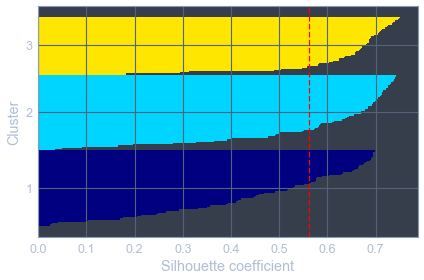

In [11]:
# Calculate the silhouette scores
silhouette_vals = silhouette_samples(X_p, partition, metric='euclidean')
# Plot the silhouette scores
cluster_labels = np.unique(partition)
n_clusters = 3
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[partition == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

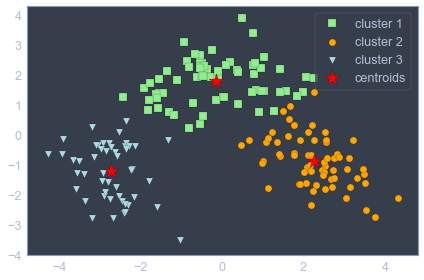

In [12]:
# Plot the output of the k-means clustering algorithm
# cluster 1
plt.scatter(X_p[partition == 0, 0],
            X_p[partition == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
# cluster 2
plt.scatter(X_p[partition == 1, 0],
            X_p[partition == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
# cluster 3
plt.scatter(X_p[partition == 2, 0],
            X_p[partition == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
# centroids 
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

* The centroid of the first cluster has approximately zero first component and has large values in second components. So according to our previous analysis of circles of correlations, wines in this cluster have the least alcohol and the least color intensity. So this cluster may represent the "mild" kind of wines.


* The centroid of the second cluster has large first component and negative second component. This means total phenols and flavanoid are important characteristics for this cluster. They also contain high amount of alcohol, and have high color intensity. This cluster may represent those "strong" wines.


* The centroid of the third cluster has negative first component and negative second component. These are the wines that have the worst taste yet they contain fair amount of alcohol!

## Wrap-up Functions

In [13]:
def clustering(X):
    # Principal Component Analysis
    X_s = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    X_p = pca.fit_transform(X_s)
    
    # Run a hierarchical clustering and select the optimal cluster size by comparing silhouette scores
    row_clusters = linkage(X_p, method='complete', metric='euclidean')
    optimal_cluster_size = 1; optimal_silhouette = -1
    for k in range(2, len(X)):
        silhouette_avg = np.mean(silhouette_samples(X_p, cut_tree(row_clusters, k).ravel(), metric='euclidean'))
        if silhouette_avg > optimal_silhouette:
            optimal_silhouette = silhouette_avg
            optimal_cluster_size = k
    print('The optimal cluster size is {}.'.format(optimal_cluster_size))

    # partition the data set using the k-means clustering algorithm
    kmeans = KMeans(n_clusters=optimal_cluster_size, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    # partition (or clustering) of the data
    partition = kmeans.fit_predict(X_p)
    
    # plot the clustering result
    for i in range(optimal_cluster_size):
        plt.scatter(X_p[partition == i, 0], X_p[partition == i, 1], s=50, label='cluster {}'.format(i))
    plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=250, marker='*', c='red', edgecolor='black', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.tight_layout()
    plt.show()
    # return the optimal number of clusters
#     return optimal_cluster_size

The optimal cluster size is 3.


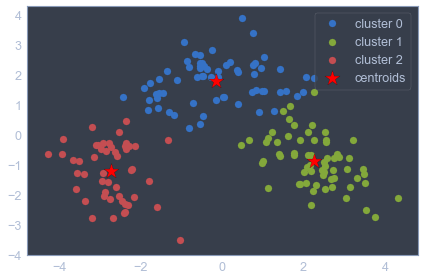

In [14]:
clustering(X)

In [15]:
def pca_circle_of_correlations(X):
    X_s = StandardScaler().fit_transform(X)
    pca = PCA()
    X_p = pca.fit_transform(X_s)
    
    for i in range(pca.n_features_ - 1):
        fig = plt.figure(figsize=(10,10))        
        number_of_subplots = pca.n_features_ - i - 1
        print('The circle of correlations of PC{} with other PCs:'.format(i))
        for j in list(range(pca.n_features_))[i+1:]:        
            PCs = pca.components_[[i, j], :]
            # Use quiver to generate the basic plot
            fig.add_subplot(max(np.ceil(number_of_subplots / 3).astype(int), 3), 3, j-i)           
            plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
                       PCs[0,:], PCs[1,:], 
                       angles='xy', scale_units='xy', scale=1)
            # Add labels based on feature names (here just numbers)
            feature_names = np.arange(PCs.shape[1])
            for p,q,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
                plt.text(q, p, z, ha='center', va='center')
            # Add unit circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='red')
            plt.gca().add_artist(circle)
            # Ensure correct aspect ratio and axis limits
            plt.axis('equal')
            plt.xlim([-1.2,1.2])
            plt.ylim([-1.2,1.2])
            # Label axes
            plt.xlabel('PC {}'.format(i))
            plt.ylabel('PC {}'.format(j))
            # Done
        plt.tight_layout()
        plt.show()

The circle of correlations of PC0 with other PCs:


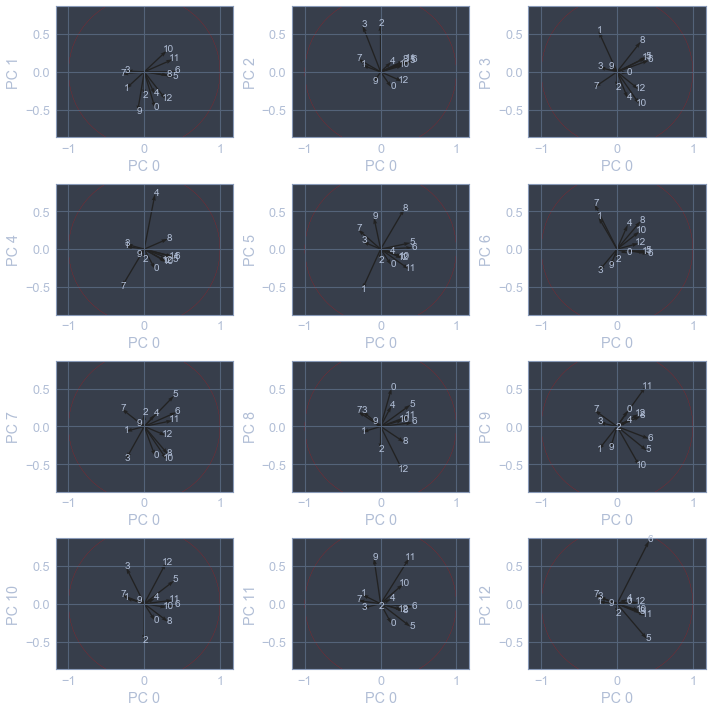

The circle of correlations of PC1 with other PCs:


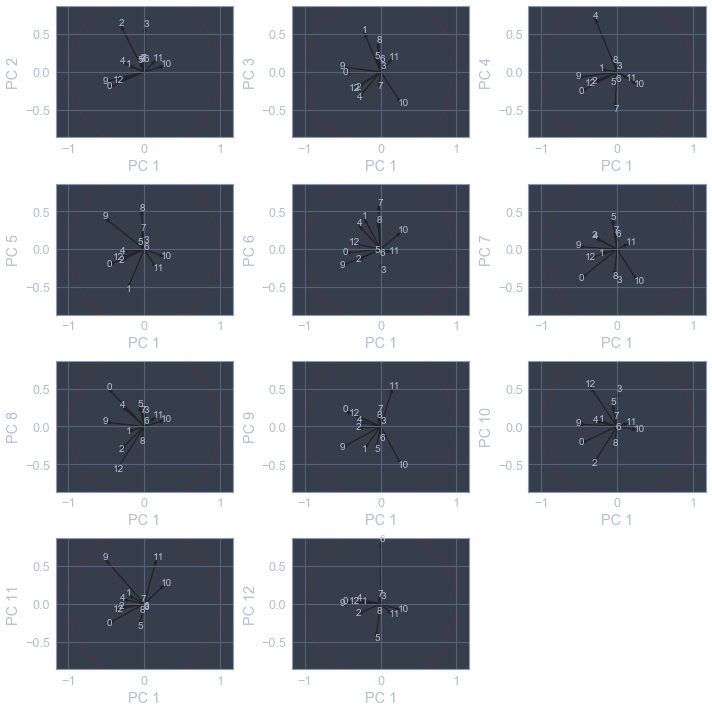

The circle of correlations of PC2 with other PCs:


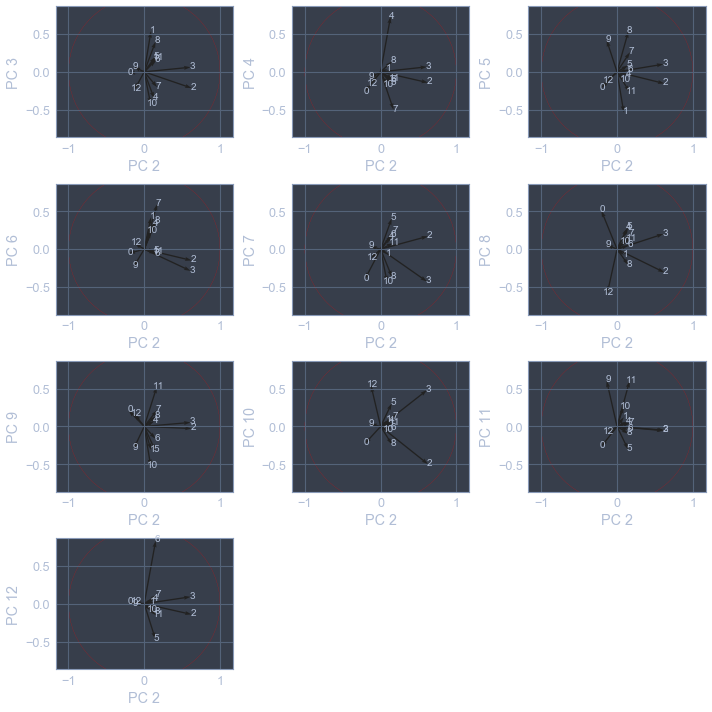

The circle of correlations of PC3 with other PCs:


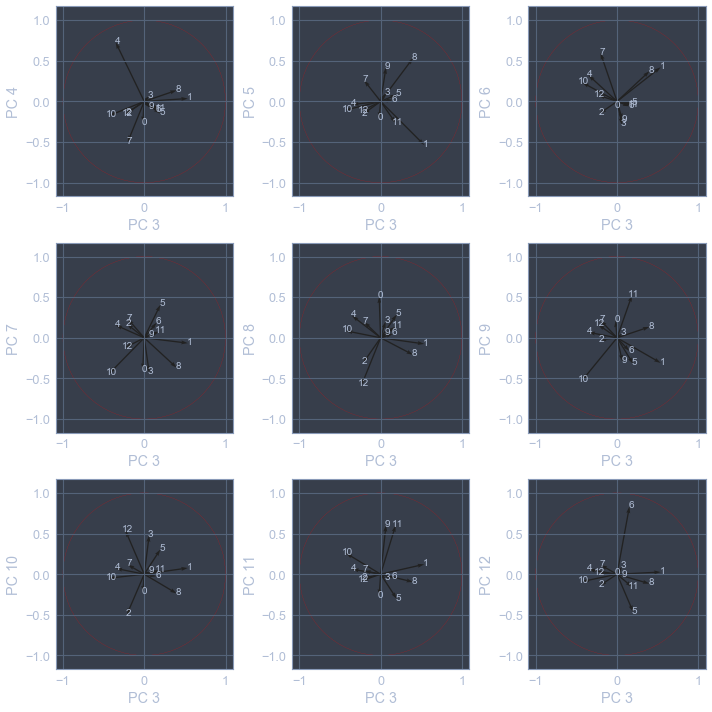

The circle of correlations of PC4 with other PCs:


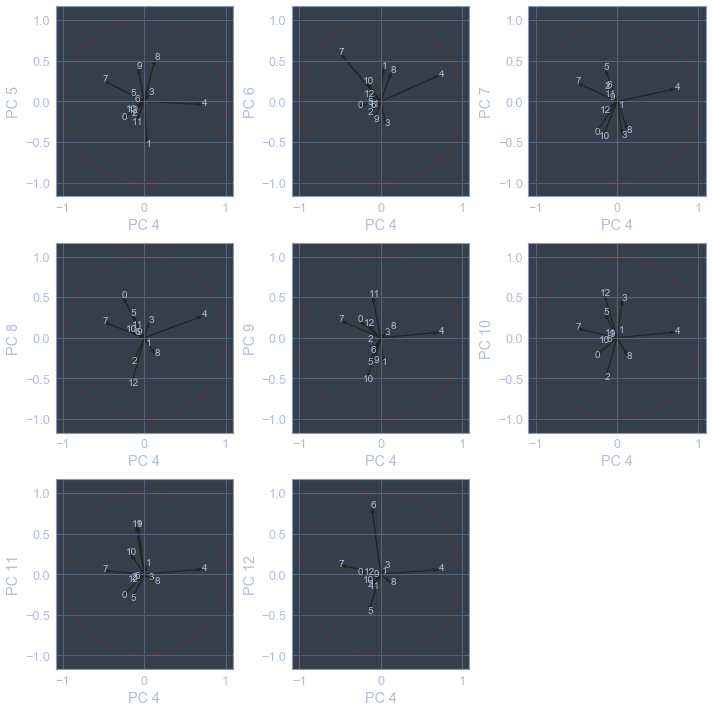

The circle of correlations of PC5 with other PCs:


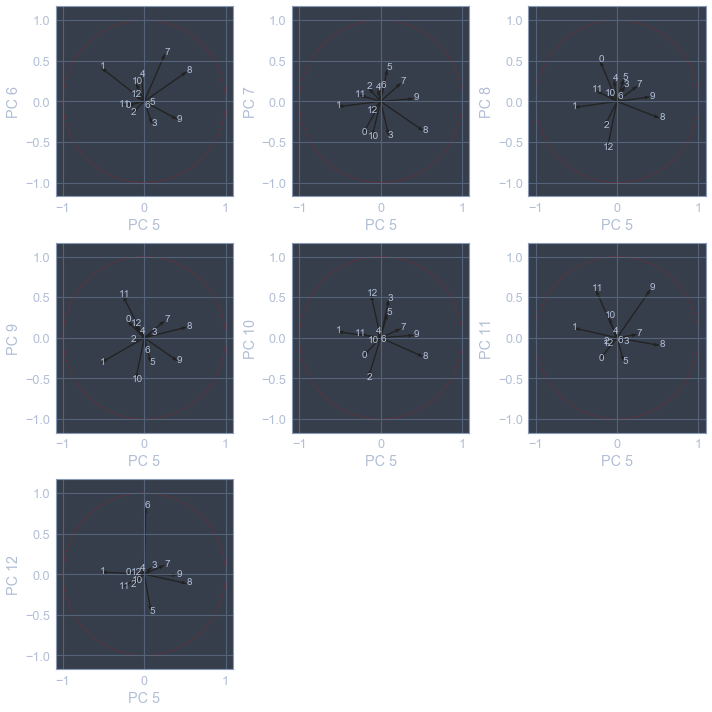

The circle of correlations of PC6 with other PCs:


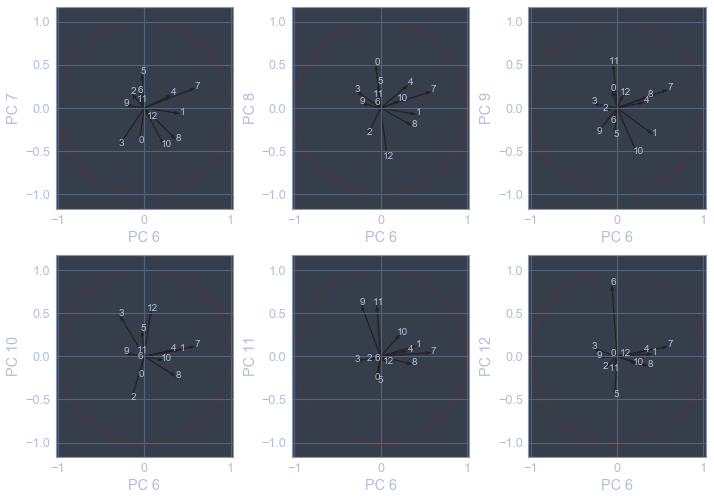

The circle of correlations of PC7 with other PCs:


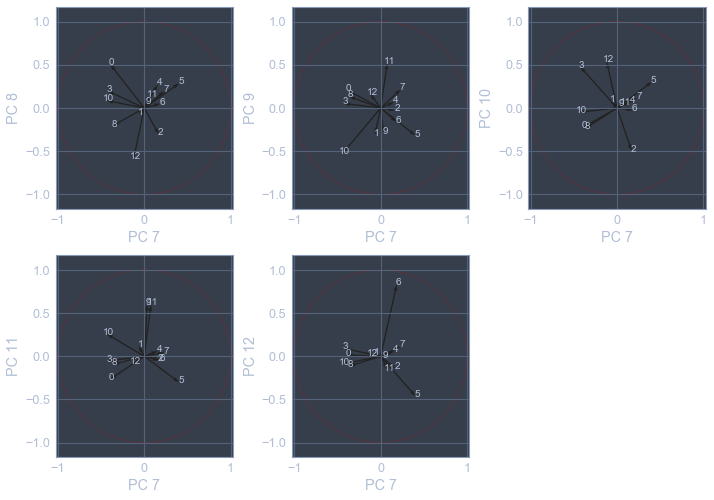

The circle of correlations of PC8 with other PCs:


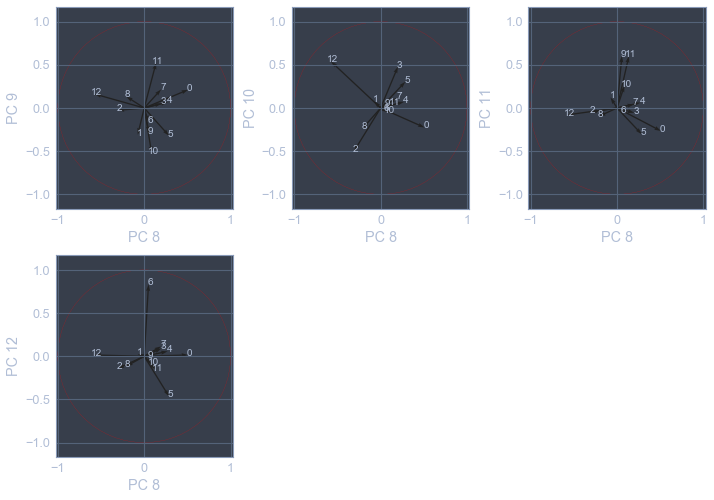

The circle of correlations of PC9 with other PCs:


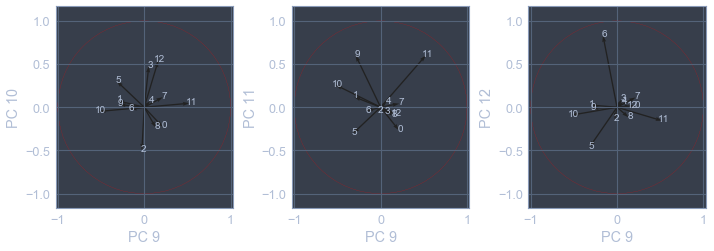

The circle of correlations of PC10 with other PCs:


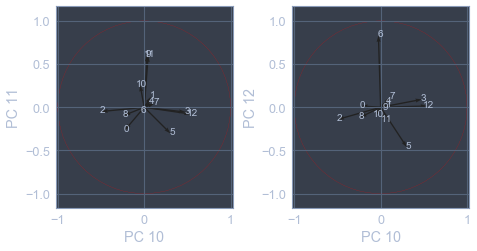

The circle of correlations of PC11 with other PCs:


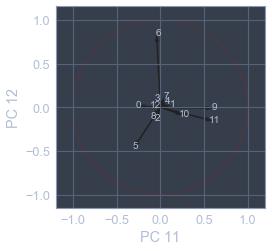

In [16]:
pca_circle_of_correlations(X)